https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
from sklearn import metrics

In [3]:
def msno_convert(val, dic):
    try:
        val = dic[val]
    except KeyError:
        val = -1
        
    return val

In [4]:
train_df = pd.read_parquet("data_p1/train_p1.parquet")

In [5]:
n_train = train_df.shape[0]
n_train

7377418

In [6]:
test_df = pd.read_parquet("data_p1/test_p1.parquet")

In [7]:
n_test = test_df.shape[0]
n_test

2556790

In [8]:
member_df = pd.read_parquet("data_p1/members_p1.parquet")

In [9]:
n_member = member_df.shape[0]

In [10]:
member_df.dtypes

city                       int64
bd                         int64
gender                    object
registered_via             int64
registration_init_time     int64
expiration_date            int64
msno_idx                   int32
dtype: object

In [11]:
song_df = pd.read_parquet("data_p1/songs_p1.parquet")

In [12]:
song_df = song_df.loc[song_df.in_data]

In [13]:
n_song = song_df.shape[0]
n_song

419781

In [14]:
song_df.dtypes

song_length      int64
genre_ids       object
artist_name     object
composer        object
lyricist        object
language       float64
artist_id        int32
song_idx         int32
in_data           bool
dtype: object

In [15]:
#song_df["genre_ids"].unique()

In [16]:
genre_unique =  song_df["genre_ids"].unique()

In [17]:
genre_dic = {}
genre_set = set()
for i in range(genre_unique.shape[0]):
    
    if genre_unique[i] is not None:
        val = genre_unique[i].split("|")
        genre_set = genre_set.union(val)
        genre_dic[genre_unique[i]] = val
        
        
    

In [18]:
len(genre_set)

172

In [19]:
song_df.shape

(419781, 9)

In [20]:
count = 0
genre_idx = {}
for val in genre_set:
    genre_idx[val] = count
    count += 1

In [21]:
n_genre = len(genre_set)
n_genre

172

In [22]:
n_song

419781

In [23]:
song_genre_mat =  np.zeros((n_song, n_genre), dtype =  bool)

In [24]:
genre_ids_array = song_df["genre_ids"].to_numpy(copy = True)

In [26]:
for i in range(n_song):
    val =  genre_ids_array[i]
    if val is not None:
        genre_list = genre_dic[val]

        for j in range(len(genre_list)):
            idx = genre_idx[genre_list[j]]

            song_genre_mat[i, idx] = True

In [27]:
song_genre_mat

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [28]:
song_genre_df = pd.DataFrame(song_genre_mat)

In [29]:
col_names = []
for i in range(n_genre):
    col_names.append("genre_" +  str(i))

1

In [42]:
#song_genre_df.columns = col_names

<AxesSubplot:>

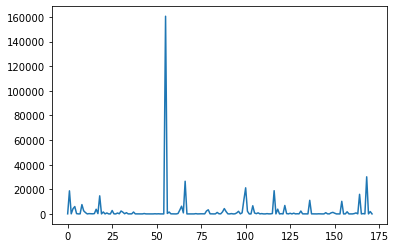

In [31]:
song_genre_df.sum().plot()

In [32]:
major_genre = np.where((song_genre_df.sum() > 5000))[0]
major_genre, major_genre.shape

(array([  1,   4,   8,  18,  55,  64,  66,  99, 100, 104, 116, 122, 136,
        154, 164, 168], dtype=int64),
 (16,))

In [36]:
song_genre_df = song_genre_df.iloc[:, major_genre]

In [40]:
cnames_genre = []
for v in major_genre:
    cnames_genre.append("genre_"+str(v))


In [43]:
song_genre_df.columns = cnames_genre

In [44]:
song_genre_df.shape, n_song

((419781, 16), 419781)

In [45]:
song_genre_df["song_idx"] = np.arange(n_song)

In [46]:
#song_genre_df = song_genre_df.merge(song_stat, on = "song_idx", how = "left")

In [48]:
song_stat

NameError: name 'song_stat' is not defined

In [46]:
train_df

,source_system_tab,source_screen_name,source_type,target,msno_idx,song_idx
0,explore,Explore,online-playlist,1,21893,1391177
1,my library,Local playlist more,local-playlist,1,26052,1584026
2,my library,Local playlist more,local-playlist,1,26052,456722
3,my library,Local playlist more,local-playlist,1,26052,1072225
4,explore,Explore,online-playlist,1,21893,518476
...,...,...,...,...,...,...
7377413,my library,Local playlist more,local-playlist,1,1605,1492444
7377414,search,Search,song,0,3927,97719
7377415,search,Search,song,1,3927,94999
7377416,discover,Discover Genre,online-playlist,1,5841,890863


In [29]:
#train_df["target2"] = train_df["target"].copy()


In [30]:
#target_array = train_df["target"].copy().to_numpy(copy = True)

In [31]:
#train_df["target2"] = target_array[::-1]*np.exp(-np.arange(n_train)/50000000)[::-1]

In [32]:
#train_df["target2"]

In [49]:
song_stat = train_df[["song_idx", "target"]].groupby("song_idx").sum().rename({"target": "Like"}, axis = 1).reset_index()
song_stat2 = train_df[["song_idx", "target"]].groupby("song_idx").count().rename({"target": "Count"}, axis = 1).reset_index()
song_stat["Count"] = song_stat2["Count"]
song_stat["Prob"] = song_stat["Like"]/ (5 + song_stat["Count"])
song_df = song_df.merge(song_stat, on = "song_idx", how = "left")

In [60]:
artist_df = song_df[["artist_id", "Like"]].groupby("artist_id").sum().reset_index()
artist_df2 = song_df[["artist_id", "Count"]].groupby("artist_id").sum().reset_index()

In [61]:
artist_df.rename({"Like":"artist_Like"}, axis = 1, inplace = True)
artist_df2.rename({"Count":"artist_Count"}, axis = 1, inplace = True)

In [69]:
artist_df["artist_Count"] = artist_df2["artist_Count"]

In [70]:
artist_df["artist_Prob"] = artist_df["artist_Like"]/(5 + artist_df["artist_Count"])  

In [74]:
#song_df.drop(["artist_score"], axis = 1, inplace = True)
artist_df

,artist_id,artist_Like,artist_Count,artist_Prob
0,2,1.0,1.0,0.166667
1,4,0.0,0.0,0.000000
2,10,0.0,0.0,0.000000
3,11,0.0,0.0,0.000000
4,13,0.0,1.0,0.000000
...,...,...,...,...
46367,222339,1.0,3.0,0.125000
46368,222341,14.0,33.0,0.368421
46369,222343,1.0,1.0,0.166667
46370,222357,13.0,17.0,0.590909


In [75]:
song_df = song_df.merge(artist_df, on = "artist_id", how = "left")

<AxesSubplot:xlabel='artist_Prob', ylabel='Prob'>

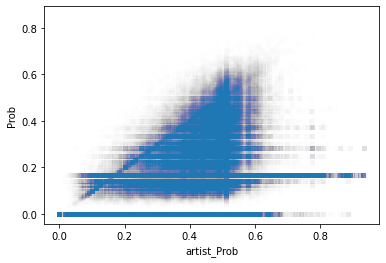

In [79]:
sns.scatterplot(data = song_df, x = "artist_Prob", y = "Prob", alpha = 0.005)

In [33]:
def cal_prob(count_0, count_1, D = 10):
    
    val = count1/(count_0+count1 + D)
    
    return val

## Source System

In [34]:
filter1 = train_df["source_system_tab"].isna()
train_df.loc[filter1, "source_system_tab"] =  "Z"

filter1 = test_df["source_system_tab"].isna()
test_df.loc[filter1, "source_system_tab"] =  "Z"

In [35]:
sources = train_df["source_system_tab"].unique()
sources_dic = {}
for i in range(sources.shape[0]):
    sources_dic[sources[i]] = i

In [36]:
train_df["sources_id"] =  train_df["source_system_tab"].apply(lambda x: sources_dic[x])
test_df["sources_id"] =  test_df["source_system_tab"].apply(lambda x: sources_dic[x])

In [45]:
def member_source_table(n_train1, n_train2):
    member_source_1 = train_df[["msno_idx", "sources_id", "target"]].iloc[n_train1:n_train2,:].groupby(["msno_idx", "sources_id"]).sum()
    member_source_01 = train_df[["msno_idx", "sources_id", "target"]].iloc[n_train1:n_train2,:].groupby(["msno_idx", "sources_id"]).count()
    member_source_df = member_source_1/(member_source_01 + 1)
    
    member_source_t = member_source_df.pivot_table(index = "msno_idx", columns = ["sources_id"])
    
    return member_source_t.to_numpy()

In [38]:
train_df2 = train_df[["target", "msno_idx", "song_idx"]]
train_df2 = train_df2.merge(song_genre_df, on =  "song_idx", how = "left")

In [322]:
n_train1 = 100000
n_train2 = 400000

In [328]:
    member_set = set(np.array(train_df[["msno_idx", "target"]].iloc[n_train1:n_train2,:].groupby(["msno_idx"]).count().query("target > 200").index))
    
    filter1 = train_df["msno_idx"].iloc[n_train1:n_train2].apply(lambda x: x in member_set)
    
    train_df3 = train_df2.drop(["song_idx"], axis = 1).iloc[n_train1:n_train2,:].loc[filter1]
    
    
    member_genre1 = train_df3.query("target == 1").groupby("msno_idx").sum()
    member_genre01 = train_df3.groupby("msno_idx").count()
    
    member_genre_prob = member_genre1/(member_genre01 + 1)
    member_genre_prob = member_genre_prob.reset_index()
    
    member_genre_prob2 = np.zeros((n_member, n_genre)) 
    
    member_genre_prob2[member_genre_prob["msno_idx"],:] = member_genre_prob.drop(["msno_idx", "target"], axis = 1).to_numpy()

In [338]:
train_df

,source_system_tab,source_screen_name,source_type,target,msno_idx,song_idx,sources_id
0,explore,Explore,online-playlist,1,21893,1391177,0
1,my library,Local playlist more,local-playlist,1,26052,1584026,1
2,my library,Local playlist more,local-playlist,1,26052,456722,1
3,my library,Local playlist more,local-playlist,1,26052,1072225,1
4,explore,Explore,online-playlist,1,21893,518476,0
...,...,...,...,...,...,...,...
7377413,my library,Local playlist more,local-playlist,1,1605,1492444,1
7377414,search,Search,song,0,3927,97719,2
7377415,search,Search,song,1,3927,94999,2
7377416,discover,Discover Genre,online-playlist,1,5841,890863,3


UndefinedVariableError: name 'genre_0' is not defined

In [330]:
member_genre_prob2[3248]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01444043,
       0.        , 0.01083032, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.06498195, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.50180505, 0.        , 0.        , 0.01083032,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
    train_df4 = train_df.iloc[n_train1:n_train2,:].loc[filter1]
    member_source_1 = train_df4[["msno_idx", "sources_id", "target"]].groupby(["msno_idx", "sources_id"]).sum()
    member_source_01 = train_df4[["msno_idx", "sources_id", "target"]].groupby(["msno_idx", "sources_id"]).count()
    member_source_df = member_source_1/(member_source_01 + 1)
    
    
    source_mean = train_df[["sources_id", "target"]].iloc[n_train1:n_train2,:].groupby("sources_id").mean()["target"].to_numpy()
    
    member_source_t = member_source_df.pivot_table(index = "msno_idx", columns = ["sources_id"]).reset_index()
    
    member_source_t2 = np.zeros((n_member, 9))
    member_source_t2[:,:] = source_mean[:]
    
    member_source_t2[member_source_t["msno_idx"],:] = member_source_t["target"]

In [164]:
def member_genre_table(n_train1, n_train2):
    
    member_set = set(np.array(train_df[["msno_idx", "target"]].iloc[n_train1:n_train2,:].groupby(["msno_idx"]).count().query("target > 200").index))
    
    filter1 = train_df["msno_idx"].iloc[n_train1:n_train2].apply(lambda x: x in member_set)
    
    train_df3 = train_df2.drop(["song_idx"], axis = 1).iloc[n_train1:n_train2,:].loc[filter1]
    
    
    member_genre1 = train_df3.query("target == 1").groupby("msno_idx").sum()
    member_genre01 = train_df3.groupby("msno_idx").count()
    
    member_genre_prob = member_genre1/(member_genre01 + 1)
    member_genre_prob = member_genre_prob.reset_index()
    
    member_genre_prob2 = np.zeros((n_member, n_genre)) 
    
    member_genre_prob2[member_genre_prob["msno_idx"],:] = member_genre_prob.drop(["msno_idx", "target"], axis = 1).to_numpy()
    

    #member_genre_prob.drop(["target"], axis = 1, inplace = True)
    #member_genre_prob = member_genre_prob.reset_index()

    train_df4 = train_df.iloc[n_train1:n_train2,:].loc[filter1]
    member_source_1 = train_df4[["msno_idx", "sources_id", "target"]].groupby(["msno_idx", "sources_id"]).sum()
    member_source_01 = train_df4[["msno_idx", "sources_id", "target"]].groupby(["msno_idx", "sources_id"]).count()
    member_source_df = member_source_1/(member_source_01 + 1)
    
    
    source_mean = train_df[["sources_id", "target"]].iloc[n_train1:n_train2,:].groupby("sources_id").mean()["target"].to_numpy()
    
    member_source_t = member_source_df.pivot_table(index = "msno_idx", columns = ["sources_id"]).reset_index()
    
    member_source_t2 = np.zeros((n_member, 9))
    member_source_t2[:,:] = source_mean[:]
    
    member_source_t2[member_source_t["msno_idx"],:] = member_source_t["target"]

    return member_set, member_genre_prob2,  member_source_t2

In [278]:
def song_tables(n_train1, n_train2):
    #return train_df[["sources_id", "target"]].iloc[0:n_train2,:].groupby("sources_id").mean()["target"].to_numpy()

    song_set = set(np.array(train_df[["song_idx", "target"]].iloc[n_train1:n_train2,:].groupby("song_idx").count().query("target > 30").index))
    
    filter1 = train_df["song_idx"].iloc[n_train1:n_train2].apply(lambda x: x in song_set)
    
    train_df3 =  train_df[["song_idx","sources_id", "target"]].iloc[n_train1:n_train2,:].loc[filter1]
    
    
    #song_mean_df = train_df[["song_idx", "target"]].iloc[n_train1:n_train2,:].groupby("song_idx").mean().reset_index()
    song_mean_df = train_df3.groupby("song_idx").mean().reset_index()
    song_mean = np.zeros(n_song+1) + 0.5
    song_mean[song_mean_df["song_idx"]+1] = song_mean_df["target"]

    #song_source_df = train_df[["song_idx","sources_id", "target"]].iloc[n_train1:n_train2,:].groupby(["song_idx", "sources_id"]).mean().reset_index()
    song_source_1 = train_df3.groupby(["song_idx", "sources_id"]).sum()#.reset_index()
    song_source_01 = train_df3.groupby(["song_idx", "sources_id"]).count()
    song_source_df = song_source_1/(song_source_01 + 1)
    
    song_source_t = song_source_df.pivot_table(index = "song_idx", columns = ["sources_id"]).reset_index()

    source_mean = train_df[["sources_id", "target"]].iloc[n_train1:n_train2,:].groupby("sources_id").mean()["target"].to_numpy()
    song_source_mat = np.zeros((n_song+1, 9)) -1
    song_source_mat[:,:] = source_mean[:]
    
    #song_source_mat2 = song_source_mat.copy()
    song_source_mat[song_source_t["song_idx"]+1] = song_source_t["target"]
    #song_source_mat[np.isnan(song_source_mat)] = song_source_mat2[np.isnan(song_source_mat)]
    
    return song_set, song_mean, source_mean, song_source_mat


0.3333333333333333

In [299]:
def predict_y(source_test, msno_test, song_test):
    
    
    n_test = source_test.shape[0]
    
    yhat_test = np.zeros(n_test)
    yhat_test[:] = np.nan
    
    count = 0
    for i in range(n_test):
        
        member = msno_test[i]
        source = source_test[i]
        song = song_test[i]+1
        
        divider = np.sum(song_genre_mat[song])
        
        val = np.nan
        if (member in member_set):
            if divider > 0:
                val = np.sum(member_genre_prob[member,:][song_genre_mat[song]])/divider
            else:
                val = member_source_mat[member, source]
                
        
        if np.isnan(val):
            if song in song_set:
                val = song_source_mat[song, source]
                if np.isnan(val):
                    val = source_mean[source]
                
            else:
                val = source_mean[source]
                
        yhat_test[i] = val
                
                
                
    return yhat_test          
            
        

        #if divider > 0:
        #    try:
        #        val1 = member_source_mat[msno_idx_loc[msno_test[i]], source_test[i]]
        #        val2 = np.sum(member_genre_mat[msno_idx_loc[msno_test[i]],:][song_genre_mat[song_test[i]+1]])/divider
                #yhat_test[i] = val1 
        #        yhat_test[i] = (val1 + val2)/2
        #    except KeyError:
        #        count += 1
                #yhat_test[i] = song_mean[song_test[i]+1]
        #        val3 = song_source_mat[song_test[i]+1, source_test[i]]
        #        yhat_test[i] = val3


        #else:

        #    yhat_test[i] = source_mean[source_test[i]]
            
            
    #return yhat_test

### Validation

In [300]:
#member_genre1 = train_df2.drop(["song_idx"], axis = 1).iloc[0:int(n_train*0.9),:].query("target == 1").groupby("msno_idx").sum()
#member_genre01 = train_df2.drop(["song_idx"], axis = 1).iloc[0:int(n_train*0.9),:].groupby("msno_idx").sum()
#member_genre_prob = member_genre1/(member_genre01 + 5)

In [301]:
#member_genre_prob.drop(["target"], axis = 1, inplace = True)
#member_genre_prob = member_genre_prob.reset_index()

In [249]:
member_set, member_genre_prob, member_source_mat = member_genre_table(int(n_train*0), int(n_train*0.9))

(array([1464., 4358., 5372., 3918., 2368., 1253.,  608.,  186.,   49.,
           6.]),
 array([0.        , 0.0962963 , 0.19259259, 0.28888889, 0.38518519,
        0.48148148, 0.57777778, 0.67407407, 0.77037037, 0.86666667,
        0.96296296]),
 <BarContainer object of 10 artists>)

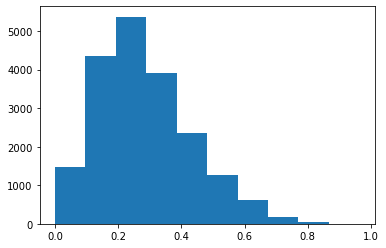

In [317]:
plt.hist(np.max(member_genre_prob[np.array(list(member_set)),], axis = 1))
    


In [297]:
song_set, song_mean, source_mean, song_source_mat = song_tables(int(n_train*0), int(n_train*0.9))

In [264]:
len(song_set)/n_song

0.0020249790969899665

In [298]:
member_source_mat

array([[       nan, 0.82695811, 0.92307692, ..., 0.93333333,        nan,
               nan],
       [0.4274928 , 0.63197489, 0.42592049, ..., 0.33359847, 0.38046461,
        0.62345374],
       [0.4274928 , 0.63197489, 0.42592049, ..., 0.33359847, 0.38046461,
        0.62345374],
       ...,
       [0.4274928 , 0.63197489, 0.42592049, ..., 0.33359847, 0.38046461,
        0.62345374],
       [       nan, 0.75862069, 0.66666667, ...,        nan,        nan,
               nan],
       [0.4274928 , 0.63197489, 0.42592049, ..., 0.33359847, 0.38046461,
        0.62345374]])

In [43]:
#member_genre_prob = member_genre_table(int(n_train*0.9))

In [46]:
#member_genre_mat = member_genre_prob.drop(["msno_idx"], axis = 1).to_numpy()

In [47]:
#member_source_mat = member_source_table(int(n_train*0.9))

In [48]:
#song_mean, source_mean, song_source_mat = song_tables(int(n_train*0.9))

In [180]:
#msno_idx_array2 = member_genre_prob["msno_idx"].to_numpy()

#msno_idx_loc = {}
#for i in range(msno_idx_array2.shape[0]):
#    msno_idx_loc[msno_idx_array2[i]] = i
    

In [252]:
msno_val = train_df["msno_idx"].iloc[int(n_train*0.9):].to_numpy()
song_val = train_df["song_idx"].iloc[int(n_train*0.9):].to_numpy()
y_val = train_df["target"].iloc[int(n_train*0.9):].to_numpy()
source_val =  train_df["sources_id"].iloc[int(n_train*0.9):].to_numpy()

In [253]:
#n_val = y_val.shape[0]
#yhat_val = np.zeros(n_val)

In [302]:
yhat_val =  predict_y(source_val, msno_val, song_val)

In [303]:
np.sum(np.isnan(yhat_val))/yhat_val.shape[0]

0.0

In [291]:
yhat_val[np.isnan(yhat_val)] = 0.5

In [304]:
np.max(yhat_val), np.min(yhat_val)

(0.9964285714285714, 0.0)

In [305]:
#yhat_val[yhat_val > 1] = 1

(array([266087., 144289., 117911.,  73043.,  65610.,  24388.,  32899.,
         10068.,   2996.,    451.]),
 array([0.        , 0.09964286, 0.19928571, 0.29892857, 0.39857143,
        0.49821429, 0.59785714, 0.6975    , 0.79714286, 0.89678571,
        0.99642857]),
 <BarContainer object of 10 artists>)

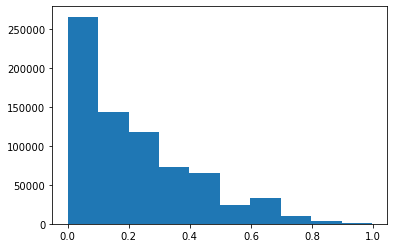

In [306]:
plt.hist(yhat_val)

In [307]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)

In [308]:
metrics.auc(fpr, tpr)

0.5491879909422714

In [287]:
metrics.auc(fpr, tpr)

0.6166836966919284

In [272]:
metrics.auc(fpr, tpr)

0.5855723996395165

In [232]:
metrics.auc(fpr, tpr)

0.6186876273435842

0.6439531677514622

0.5090993819703922

### Test

In [274]:
song_mean_df = train_df[["song_idx", "target"]].groupby("song_idx").mean().reset_index()
song_mean = np.zeros(n_song+1) + 0.5
song_mean[song_mean_df["song_idx"]+1] = song_mean_df["target"]

song_source_df = train_df[["song_idx","sources_id", "target"]].groupby(["song_idx", "sources_id"]).mean().reset_index()

song_source_t = song_source_df.pivot_table(index = "song_idx", columns = ["sources_id"]).reset_index()

source_mean = train_df[["sources_id", "target"]].groupby("sources_id").mean()["target"].to_numpy()


song_source_mat = np.zeros((n_song+1, 9)) -1


song_source_mat[:,:] = source_mean[:]
song_source_mat2 = song_source_mat.copy()
song_source_mat[song_source_t["song_idx"]+1] = song_source_t["target"]
song_source_mat[np.isnan(song_source_mat)] = song_source_mat2[np.isnan(song_source_mat)]

(2296321, 2296320)

In [278]:
song_source_t

song_idx    target                                              \
sources_id                  0         1         2         3    4        5   
0                -1  0.000000  0.546875  0.315789  0.125000  NaN  0.20000   
1                 0       NaN  0.625000       NaN  0.000000  NaN      NaN   
2                 1  0.551402  0.803045  0.703125  0.503790  0.6  0.34375   
3                 2  0.454545  0.625806  0.346154  0.339806  0.0  0.00000   
4                 3       NaN  0.614634  0.282609  0.450000  0.0  0.00000   
...             ...       ...       ...       ...       ...  ...      ...   
359910      2296048       NaN       NaN       NaN  0.000000  NaN      NaN   
359911      2296161       NaN       NaN  0.000000       NaN  NaN      NaN   
359912      2296187       NaN  0.000000       NaN       NaN  NaN      NaN   
359913      2296259       NaN  0.000000       NaN       NaN  NaN      NaN   
359914      2296280       NaN  0.000000       NaN       NaN  NaN      NaN   

                               
sources_id         6    7   8  
0           0.500000  NaN NaN  
1           0.000000  NaN NaN  
2           0.090909  1.0 NaN  
3           0.166667  NaN NaN  
4           0.288889  NaN NaN  
...              ...  ...  ..  
359910           NaN  NaN NaN  
359911           NaN  NaN NaN  
359912           NaN  NaN NaN  
359913           NaN  NaN NaN  
359914           NaN  NaN NaN  

[359915 rows x 10 columns]

In [280]:
source_mean

array([0.42214601, 0.61965897, 0.42136194, 0.41576972, 0.51036259,
       0.22266158, 0.3265808 , 0.37801132, 0.59090909])

In [51]:
member_genre1 = train_df2.drop(["song_idx"], axis = 1).query("target == 1").groupby("msno_idx").sum()
member_genre01 = train_df2.drop(["song_idx"], axis = 1).groupby("msno_idx").sum()
member_genre_prob = member_genre1/(member_genre01 + 0.5)

In [52]:
member_genre_prob.drop(["target"], axis = 1, inplace = True)
member_genre_prob = member_genre_prob.reset_index()

In [53]:
member_genre_mat = member_genre_prob.drop(["msno_idx"], axis = 1).to_numpy()

In [54]:
msno_idx_array2 = member_genre_prob["msno_idx"].to_numpy()

msno_idx_loc = {}
for i in range(msno_idx_array2.shape[0]):
    msno_idx_loc[msno_idx_array2[i]] = i

In [77]:
member_genre_mat.shape[0]/n_member

0.8939627358079237

In [288]:
msno_test = test_df["msno_idx"].to_numpy()
song_test = test_df["song_idx"].to_numpy()

In [289]:
source_test = test_df["sources_id"].to_numpy()

In [306]:
yhat_test = np.zeros(n_test)

In [307]:
member_source_mat.shape, member_genre_mat.shape

((30755, 9), (30755, 191))

In [308]:
count = 0
for i in range(n_test):
    divider = np.sum(song_genre_mat[song_test[i]+1])
    
    if divider > 0:
        try:
            val1 = member_source_mat[msno_idx_loc[msno_test[i]], source_test[i]]
            #val2 = np.sum(member_genre_mat[msno_idx_loc[msno_test[i]],:][song_genre_mat[song_test[i]+1]])/divider
            yhat_test[i] = val1 
            #yhat_test[i] = (val1 + val2)/2
        except KeyError:
            count += 1
            #yhat_test[i] = song_mean[song_test[i]+1]
            val3 = song_source_mat[song_test[i]+1, source_test[i]]
            
            
    else:
        
        yhat_test[i] = source_mean[source_test[i]]

(array([306250., 154584., 250163., 333811., 406554., 336694., 287937.,
        192755., 132836.,  64526.]),
 array([0.        , 0.09992759, 0.19985518, 0.29978277, 0.39971035,
        0.49963794, 0.59956553, 0.69949312, 0.79942071, 0.8993483 ,
        0.99927589]),
 <BarContainer object of 10 artists>)

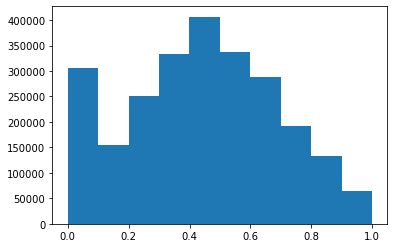

In [309]:
plt.hist(yhat_test)

In [315]:
np.sum(np.isnan(yhat_test))/n_test

0.0

In [311]:
filter1 = np.isnan(yhat_test)
yhat_test[np.isnan(yhat_test)] = source_mean[source_test[filter1]]

In [312]:
count/n_test

0.07067181896049343

In [313]:
yhat_test.max(),yhat_test.min()

(0.999275887038378, 0.0)

(array([306250., 154584., 280143., 345198., 440905., 339937., 299656.,
        192755., 132836.,  64526.]),
 array([0.        , 0.09992759, 0.19985518, 0.29978277, 0.39971035,
        0.49963794, 0.59956553, 0.69949312, 0.79942071, 0.8993483 ,
        0.99927589]),
 <BarContainer object of 10 artists>)

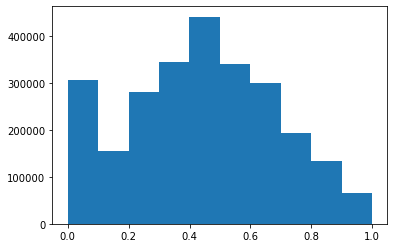

In [314]:
plt.hist(yhat_test)

In [316]:
sample_df = pd.read_parquet("data/sample_submission.parquet")

In [317]:
sample_df["target"] = yhat_test

In [318]:
sample_df.to_csv("output/Content_Source_1.csv", index = False)

In [152]:
train_df["target"].mean()

0.5035170841614234

In [156]:
train_df[["source_system_tab", "target"]].groupby("source_system_tab").mean().sort_values("target")

,target
source_system_tab,
radio,0.222662
listen with,0.326581
notification,0.378011
discover,0.415770
search,0.421362
explore,0.422146
settings,0.590909
my library,0.619659


<AxesSubplot:xlabel='source_system_tab'>

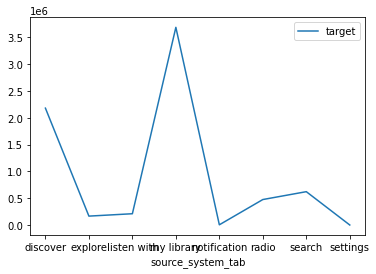

In [154]:
train_df[["source_system_tab", "target"]].groupby("source_system_tab").count().plot()

<AxesSubplot:xlabel='source_system_tab'>

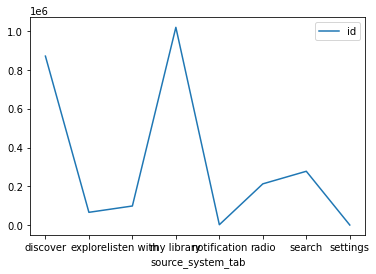

In [153]:
test_df[["source_system_tab", "id"]].groupby("source_system_tab").count().plot()

In [170]:
member_source_t

target                                                \
source_system_tab  discover   explore listen with my library notification   
msno_idx                                                                    
0                  0.095238       NaN    0.938547   0.830493          NaN   
1                  0.000000       NaN         NaN        NaN          NaN   
2                  0.580645  0.235294         NaN        NaN          NaN   
3                  0.000000       NaN         NaN        NaN          NaN   
4                  0.000000       NaN         NaN        NaN          NaN   
...                     ...       ...         ...        ...          ...   
34398              0.609062       NaN         NaN        NaN          NaN   
34399                   NaN       NaN         NaN   0.830189          NaN   
34400                   NaN       NaN         NaN   0.322581          NaN   
34401                   NaN       NaN         NaN   0.755418          NaN   
34402                   NaN       NaN         NaN   0.260870          NaN   

                                            
source_system_tab radio    search settings  
msno_idx                                    
0                   NaN  0.960000      NaN  
1                   NaN       NaN      NaN  
2                   NaN       NaN      NaN  
3                   NaN       NaN      NaN  
4                   NaN  0.000000      NaN  
...                 ...       ...      ...  
34398               NaN       NaN      NaN  
34399               NaN       NaN      NaN  
34400               NaN       NaN      NaN  
34401               NaN  0.857143      NaN  
34402               NaN       NaN      NaN  

[30647 rows x 8 columns]

In [199]:
member_source_t

target                                                         
sources_id         0         1         2         3    4   5         6   7   8
msno_idx                                                                     
0                NaN  0.830493  0.960000  0.095238  NaN NaN  0.938547 NaN NaN
1                NaN       NaN       NaN  0.000000  NaN NaN       NaN NaN NaN
2           0.235294       NaN       NaN  0.580645  NaN NaN       NaN NaN NaN
3                NaN       NaN       NaN  0.000000  NaN NaN       NaN NaN NaN
4                NaN       NaN  0.000000  0.000000  NaN NaN       NaN NaN NaN
...              ...       ...       ...       ...  ...  ..       ...  ..  ..
34398            NaN       NaN       NaN  0.609062  NaN NaN       NaN NaN NaN
34399            NaN  0.830189       NaN       NaN  0.0 NaN       NaN NaN NaN
34400            NaN  0.322581       NaN       NaN  NaN NaN       NaN NaN NaN
34401            NaN  0.755418  0.857143       NaN  NaN NaN       NaN NaN NaN
34402            NaN  0.260870       NaN       NaN  NaN NaN       NaN NaN NaN

[30755 rows x 9 columns]